In [1]:
# Read in existing demo

import pickle

demo = pickle.load(open('/home/anton/Documents/Yale/HCP/demographics.pkl', 'rb'))

print('Done')

Done


In [2]:
sorted(list(demo.keys()))

['Age_in_Yrs',
 'BMI',
 'BPDiastolic',
 'BPSystolic',
 'Gender',
 'Height',
 'Hematocrit_1',
 'PSQI_Score',
 'Race',
 'SSAGA_Mj_Use',
 'Strength_Unadj',
 'Total_Any_Tobacco_7days',
 'Total_Drinks_7days',
 'Weight']

In [3]:
# List fields

desc = sorted(list(demo.keys()))

fields = desc

types = ['continuous', 'continuous', 'continuous', 'continuous',
         'categorical', 'continuous', 'continuous', 'continuous',
         'categorical', 'categorical', 'continuous', 'continuous',
         'continuous', 'continuous'
        ]

In [4]:
# Get subs with all values

keepSubs = []

for sub in demo['Age_in_Yrs']:
    exclude = False
    for field in list(demo.keys()):
        if sub not in demo[field]:
            exclude = True
    if not exclude:
        keepSubs.append(sub)

print(len(keepSubs))

1067


In [5]:
# Get FC

import numpy as np

fcsPkl = pickle.load(open('/home/anton/Documents/Yale/HCP/fcs_ya.pkl', 'rb'))
fcs = []

for sub in keepSubs:
    sub = str(sub)
    if sub in fcsPkl:
        fcs.append(fcsPkl[sub])

x = np.stack(fcs)

print(len(x))

456


In [6]:
for i in range(len(fields)):
    print(i, fields[i])

0 Age_in_Yrs
1 BMI
2 BPDiastolic
3 BPSystolic
4 Gender
5 Height
6 Hematocrit_1
7 PSQI_Score
8 Race
9 SSAGA_Mj_Use
10 Strength_Unadj
11 Total_Any_Tobacco_7days
12 Total_Drinks_7days
13 Weight


In [7]:
demos = [[] for field in fields]

for sub in keepSubs:
    if str(sub) in fcsPkl:
        for i in range(len(fields)):
            if fields[i] == 'Gender':
                val = int(demo[fields[i]][sub] == 'M')
            elif fields[i] == 'Race':
                val = int(demo[fields[i]][sub] == 'White')
            else:
                val = demo[fields[i]][sub]
            demos[i].append(val)

print('Done')

Done


In [8]:
# Get statistics for demographics

didx = 6

print(np.mean(demos[didx]), np.std(demos[didx]))
# print(np.mean(demos[didx] == np.ones(456)), np.mean(demos[didx] != np.ones(456)))

43.25877192982456 4.860660402093035


In [9]:
# Choose demographic fields
# Since the model is unstable with more than about 5
# Keep age, gender, weight, and height in all demos and just vary the last one
# Do not keep track of race

nums = [0, 1]
special_demo = fields[nums[-1]]

reduced_demos = [np.array(demos[i]) for i in nums]
reduced_types = [types[i] for i in nums]

# reduced_demos[4] = reduced_demos[4]

print(len(reduced_demos))
print(special_demo)

2
BMI


In [10]:
import sys

sys.path.append('/home/anton/Documents/Tulane/Research/demo-vae/pip/src/')

from demovae import DemoVAE

In [12]:
vae = DemoVAE(pperiod=50, use_cuda=True, nepochs=1000, latent_dim=100, weight_decay=0, lr=5e-5, loss_rec_mult=1e3,
              loss_pred_mult=0.01, loss_C_mult=1e4)
vae.fit(x, reduced_demos, reduced_types)

Fitting auxilliary guidance model for demographic 0 continuous... done
 doneng auxilliary guidance model for demographic 1 continuous...
Converting input to pytorch
Converting demographics to pytorch
Beginning VAE training
Epoch 0 ReconLoss 0.8849 CovarianceLoss 45.5202 MeanLoss 0.0332 DecorLoss 3.1387 GuidanceTargets [32.58281326293945, 24.17867660522461] GuidanceLosses ['9.1493', '3.8175'] 
Epoch 50 ReconLoss 0.1968 CovarianceLoss 34.8996 MeanLoss 0.0982 DecorLoss 0.1946 GuidanceTargets [32.609886169433594, 28.309162139892578] GuidanceLosses ['3.0703', '2.2449'] 
Epoch 100 ReconLoss 0.2248 CovarianceLoss 11.2068 MeanLoss 0.108 DecorLoss 0.1211 GuidanceTargets [23.070938110351562, 23.308549880981445] GuidanceLosses ['2.7196', '2.0246'] 
Epoch 150 ReconLoss 0.2013 CovarianceLoss 2.6824 MeanLoss 0.1131 DecorLoss 0.1137 GuidanceTargets [25.4937686920166, 22.99539566040039] GuidanceLosses ['2.9207', '2.4007'] 
Epoch 200 ReconLoss 0.1739 CovarianceLoss 0.9392 MeanLoss 0.096 DecorLoss 0.114

DemoVAE(LR_C=100, alpha=100, bsize=1000, latent_dim=100, loss_C_mult=10000.0,
        loss_decor_mult=10, loss_mu_mult=1, loss_pred_mult=0.01,
        loss_rec_mult=1000.0, lr=5e-05, nepochs=1000, pperiod=50, use_cuda=True,
        weight_decay=0)

In [13]:
synth = vae.transform(len(x), reduced_demos, reduced_types)

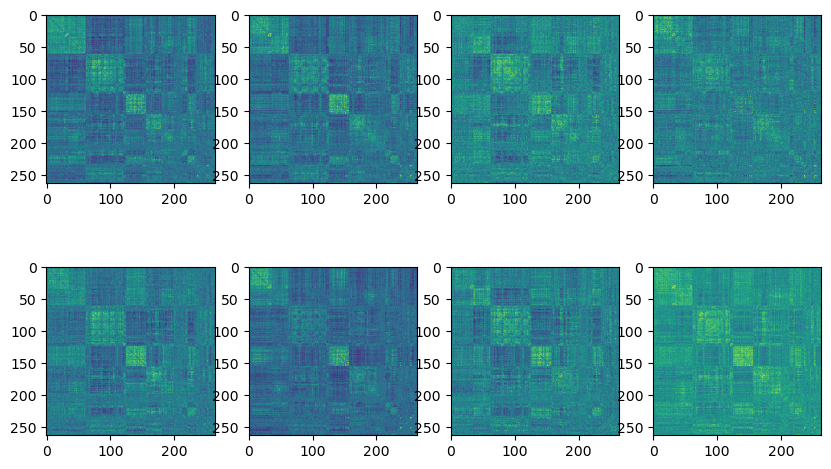

In [14]:
def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, figsize=(10,6))

for i in range(2):
    for j in range(4):
        ax[i,j].imshow(vec2mat(synth[10+i*4+j]))

fig.show()

In [15]:
vae.save(f'/home/anton/Documents/Yale/HCP/VAE_Models/456_subs/{special_demo}.pkl')

print('Done save')

Done save


In [16]:
import pickle

pickle.dump({'demos': reduced_demos, 'types': reduced_types}, 
            open(f'/home/anton/Documents/Yale/HCP/VAE_Models/456_subs/demos_{special_demo}.pkl', 'wb'))

print('Done')
print(special_demo)

Done
BMI
